# Predicting Sunspots 

In [1]:
# Libray imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [4]:
# Custom function to plot a series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Load the dataset
dataset = pd.read_csv("resources/Sunspots.csv")

# Conversion relevant fields to numpy array
tim_step = np.array(dataset['Date'])
sunspots = np.array(dataset['Monthly Mean Total Sunspot Number'])

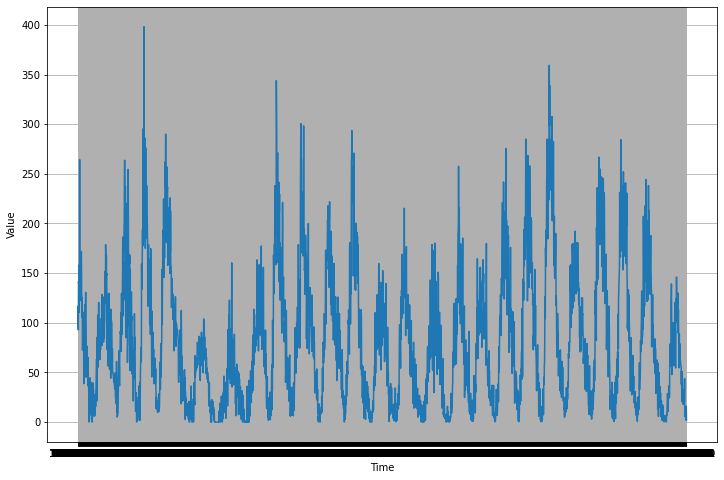

In [5]:
# Plot the series
plt.figure(figsize=(12, 8))
plot_series(tim_step, sunspots)

In [6]:
# Define some constants
split_time = 3500
tim_step_train = tim_step[:split_time]
sunspots_train = sunspots[:split_time]
tim_step_valid = tim_step[split_time:]
sunspots_valid = sunspots[split_time:]

window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
# Prepared the windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [12]:
# Prepare the dataset for training
dataset = windowed_dataset(sunspots_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [13]:

model_dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[window_size], activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
])

model_dnn.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9))
model_dnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit the model
model_dnn.fit(dataset, epochs=100, verbose=1)

2021-12-16 11:17:08.334834: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
100/100 [==============================] - 1s 3ms/step - loss: 8812.2602
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 864.0204
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 733.2774
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 734.0150
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 711.7132
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 725.3012
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 685.5922
Epoch 8/100
100/100 [==============================] - 0s 3ms/step - loss: 699.2805
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 652.0040
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 705.5601
Epoch 11/100
100/100 [==============================] - 0s 2ms/step - loss: 698.8995
Epoch 12/100
100/100 [==============================] - 0s 2ms/step - los

In [16]:
# Perform the forecast
forecast=[]
for time in range(len(sunspots) - window_size):
  forecast.append(model_dnn.predict(sunspots[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(tim_step_valid, sunspots_valid)
plot_series(tim_step_valid, results)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [18]:
tf.keras.metrics.mean_absolute_error(sunspots_valid, results).numpy()

NameError: name 'results' is not defined